In [24]:
import pandas as pd
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"
import sqlite3
from flask import Flask, jsonify
from datetime import datetime


In [3]:
data = pd.read_excel("/analysis_task_data.xlsx")
print(data.tail(5))


       hour                time  Wind Day Ahead Forecast [in MW]  \
35035    22 2021-12-31 22:45:00                            37367   
35036    23 2021-12-31 23:00:00                            37087   
35037    23 2021-12-31 23:15:00                            36786   
35038    23 2021-12-31 23:30:00                            36484   
35039    23 2021-12-31 23:45:00                            36155   

       Wind Intraday Forecast [in MW]  PV Day Ahead Forecast [in MW]  \
35035                           33010                              0   
35036                           32409                              0   
35037                           32149                              0   
35038                           31755                              0   
35039                           31361                              0   

       PV Intraday Forecast [in MW]  Day Ahead Price hourly [in EUR/MWh]  \
35035                             0                                 5.10   
35036 

In [4]:
print(data.columns)


Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]'],
      dtype='object')


In [5]:
print(data.dtypes)

hour                                                          int64
time                                                 datetime64[ns]
Wind Day Ahead Forecast [in MW]                               int64
Wind Intraday Forecast [in MW]                                int64
PV Day Ahead Forecast [in MW]                                 int64
PV Intraday Forecast [in MW]                                  int64
Day Ahead Price hourly [in EUR/MWh]                         float64
Intraday Price Price Quarter Hourly  [in EUR/MWh]           float64
Intraday Price Hourly  [in EUR/MWh]                         float64
Imbalance Price Quarter Hourly  [in EUR/MWh]                float64
dtype: object


Task 1.1

In [6]:

db_path = "/trades.sqlite"

try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    print("Tables in the database:")
    for table in tables:
        print(table[0])

except sqlite3.Error as e:
    print(f"Database error: {e}")

finally:
    if conn:
        conn.close()

Tables in the database:
epex_12_20_12_13


The table name is actually "epex_12_20_12_13"

In [8]:
table_name = "epex_12_20_12_13"
try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = f'SELECT * FROM "{table_name}" '
    cursor.execute(query)
    rows = cursor.fetchall()

    print(f"Head of the table '{table_name}':")
    for row in rows:
        print(row)

except sqlite3.Error as e:
    print(f"Database error: {e}")

finally:
    if conn:
        conn.close()

Head of the table 'epex_12_20_12_13':
('trade_1', 5, 20.0, 'buy', 'strategy_1')
('trade_2', 17, 10.0, 'sell', 'strategy_1')
('trade_3', 15, 8.0, 'buy', 'strategy_1')
('trade_4', 13, 35.0, 'sell', 'strategy_2')
('trade_5', 23, 11.0, 'sell', 'strategy_2')
('trade_6', 8, 20.0, 'buy', 'strategy_2')


In [7]:

def compute_total_buy_volume(db_path: str, table_name: str) -> float:

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = f"""
        SELECT SUM(quantity)
        FROM "{table_name}"
        WHERE side = 'buy';
        """

        cursor.execute(query)
        result = cursor.fetchone()
        total_buy_volume = result[0] if result[0] is not None else 0.0

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        total_buy_volume = 0.0

    finally:
        if conn:
            conn.close()

    return total_buy_volume

def compute_total_sell_volume(db_path: str, table_name: str) -> float:

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = f"""
        SELECT SUM(quantity)
        FROM "{table_name}"
        WHERE side = 'sell';
        """

        cursor.execute(query)
        result = cursor.fetchone()
        total_sell_volume = result[0] if result[0] is not None else 0.0

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        total_sell_volume = 0.0

    finally:
        if conn:
            conn.close()

    return total_sell_volume


if __name__ == "__main__":
    db_path = "/trades.sqlite"
    table_name = "epex_12_20_12_13"

    buy_volume = compute_total_buy_volume(db_path, table_name)
    sell_volume = compute_total_sell_volume(db_path, table_name)

    print(f"Total Buy Volume: {buy_volume}")
    print(f"Total Sell Volume: {sell_volume}")


Total Buy Volume: 28
Total Sell Volume: 53


Task 1.2

In [9]:
def compute_pnl(strategy_id: str, db_path: str, table_name: str) -> float:

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = f"""
        SELECT SUM(CASE
                    WHEN side = 'buy' THEN -quantity * price
                    WHEN side = 'sell' THEN quantity * price
                    ELSE 0
                    END)
        FROM "{table_name}"
        WHERE strategy = ?;
        """

        cursor.execute(query, (strategy_id,))
        result = cursor.fetchone()
        pnl = result[0] if result[0] is not None else 0.0

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        pnl = 0.0

    finally:
        if conn:
            conn.close()

    return pnl

if __name__ == "__main__":
    db_path = "/trades.sqlite"
    table_name = "epex_12_20_12_13"
    strategy_id_1 = "strategy_1"
    strategy_id_2 = "strategy_2"

    pnl = compute_pnl(strategy_id_1, db_path, table_name)
    print(f"PnL for strategy 1'{strategy_id_1}': {pnl} euros")

    pnl = compute_pnl(strategy_id_2, db_path, table_name)
    print(f"PnL for strategy 2'{strategy_id_2}': {pnl} euros")


PnL for strategy 1'strategy_1': -50.0 euros
PnL for strategy 2'strategy_2': 548.0 euros


Task 1.3

In [26]:
app = Flask(__name__)

def compute_pnl(strategy_id: str, db_path: str, table_name: str) -> float:

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = f"""
        SELECT SUM(CASE
                    WHEN side = 'buy' THEN -quantity * price
                    WHEN side = 'sell' THEN quantity * price
                    ELSE 0
                    END)
        FROM "{table_name}"
        WHERE strategy = ?;
        """

        cursor.execute(query, (strategy_id,))
        result = cursor.fetchone()
        pnl = result[0] if result[0] is not None else 0.0

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        pnl = 0.0

    finally:
        if conn:
            conn.close()

    return pnl


@app.route('/v1/pnl/<strategy_id>', methods=['GET'])
def get_pnl(strategy_id: str):

    db_path = "/trades.sqlite"
    table_name = "epex_12_20_12_13"

    pnl_value = compute_pnl(strategy_id, db_path, table_name)

    response_data = {
        "strategy": strategy_id,
        "value": pnl_value,
        "unit": "euro",
        "capture_time": datetime.utcnow().isoformat() + "Z"
    }

    return jsonify(response_data)


if __name__ == "__main__":
    app.run(debug=True, host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


Task 2.1

In [12]:

data_2021 = data[data['time'].dt.year == 2021]

data_2021['Wind_DA_MWh'] = data_2021['Wind Day Ahead Forecast [in MW]'] * 0.25
data_2021['Wind_ID_MWh'] = data_2021['Wind Intraday Forecast [in MW]'] * 0.25
data_2021['PV_DA_MWh'] = data_2021['PV Day Ahead Forecast [in MW]'] * 0.25
data_2021['PV_ID_MWh'] = data_2021['PV Intraday Forecast [in MW]'] * 0.25

wind_da_total = data_2021['Wind_DA_MWh'].sum()
wind_id_total = data_2021['Wind_ID_MWh'].sum()
pv_da_total = data_2021['PV_DA_MWh'].sum()
pv_id_total = data_2021['PV_ID_MWh'].sum()

print(f"Total Wind Day Ahead (2021): {wind_da_total:.2f} MWh")
print(f"Total Wind Intraday (2021): {wind_id_total:.2f} MWh")
print(f"Total PV Day Ahead (2021): {pv_da_total:.2f} MWh")
print(f"Total PV Intraday (2021): {pv_id_total:.2f} MWh")

Total Wind Day Ahead (2021): 115395406.25 MWh
Total Wind Intraday (2021): 113478034.50 MWh
Total PV Day Ahead (2021): 46094572.75 MWh
Total PV Intraday (2021): 46689891.50 MWh


Task 2.2

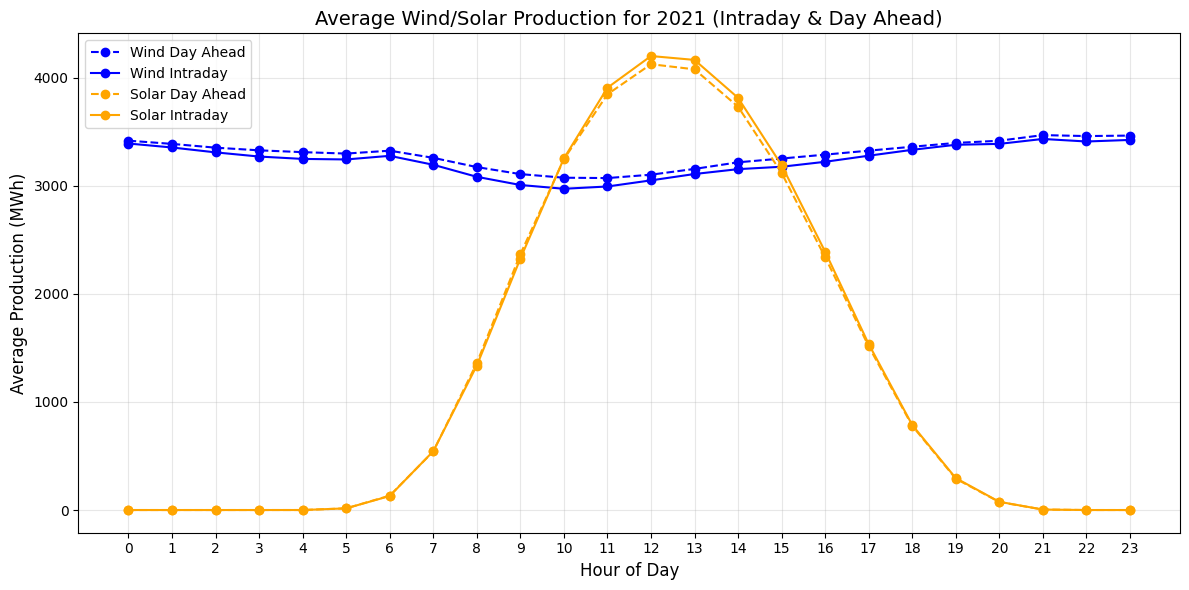

In [13]:
average_wind_da = data_2021.groupby('hour')['Wind_DA_MWh'].mean()
average_wind_id = data_2021.groupby('hour')['Wind_ID_MWh'].mean()
average_pv_da = data_2021.groupby('hour')['PV_DA_MWh'].mean()
average_pv_id = data_2021.groupby('hour')['PV_ID_MWh'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_wind_da, label="Wind Day Ahead", color='blue', linestyle='--', marker='o')
plt.plot(average_wind_id, label="Wind Intraday", color='blue', linestyle='-', marker='o')
plt.plot(average_pv_da, label="Solar Day Ahead", color='orange', linestyle='--', marker='o')
plt.plot(average_pv_id, label="Solar Intraday", color='orange', linestyle='-', marker='o')

plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Production (MWh)", fontsize=12)
plt.title("Average Wind/Solar Production for 2021 (Intraday & Day Ahead)", fontsize=14)
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()

plt.show()

Task 2.3

In [14]:
data_2021['Wind_DA_revenue'] = data_2021['Wind_DA_MWh'] * data_2021['Day Ahead Price hourly [in EUR/MWh]']
data_2021['PV_DA_revenue'] = data_2021['PV_DA_MWh'] * data_2021['Day Ahead Price hourly [in EUR/MWh]']

avg_wind_revenue = data_2021['Wind_DA_revenue'].mean()
avg_pv_revenue = data_2021['PV_DA_revenue'].mean()

avg_da_price = data_2021['Day Ahead Price hourly [in EUR/MWh]'].mean()

print(f"Average Wind Revenue (2021): {avg_wind_revenue:.2f} EUR/MWh")
print(f"Average PV Revenue (2021): {avg_pv_revenue:.2f} EUR/MWh")
print(f"Average Day Ahead Price (2021): {avg_da_price:.2f} EUR/MWh")

if avg_wind_revenue > avg_da_price:
    print("Wind average revenue is higher than the average DA price.")
else:
    print("Wind average revenue is lower than the average DA price.")

if avg_pv_revenue > avg_da_price:
    print("PV average revenue is higher than the average DA price.")
else:
    print("PV average revenue is lower than the average DA price.")

Average Wind Revenue (2021): 268027.80 EUR/MWh
Average PV Revenue (2021): 101153.55 EUR/MWh
Average Day Ahead Price (2021): 96.85 EUR/MWh
Wind average revenue is higher than the average DA price.
PV average revenue is higher than the average DA price.


Wind/PV average revenue could be higher or lower than the DA price. That depends on several factors including uncertainty in the wind and solar power forecasts (Day ahead forecast), volatility in the Day Ahead price and time-of-day effect.

Task 2.4

In [15]:
data_2021['date'] = data_2021['time'].dt.date

data_2021['total_renewable'] = data_2021['Wind_DA_MWh'] + data_2021['PV_DA_MWh']

daily_data = data_2021.groupby('date').agg({
    'total_renewable': 'sum',
    'Day Ahead Price hourly [in EUR/MWh]': 'mean'
}).reset_index()

max_renewable_day = daily_data.loc[daily_data['total_renewable'].idxmax()]
min_renewable_day = daily_data.loc[daily_data['total_renewable'].idxmin()]

print(f"Day with Highest Renewable Energy Production: {max_renewable_day['date']}")
print(f"Total Renewable Energy on this day: {max_renewable_day['total_renewable']:.2f} MWh")
print(f"Average Day Ahead Price on this day: {max_renewable_day['Day Ahead Price hourly [in EUR/MWh]']:.2f} EUR/MWh")

print(f"Day with Lowest Renewable Energy Production: {min_renewable_day['date']}")
print(f"Total Renewable Energy on this day: {min_renewable_day['total_renewable']:.2f} MWh")
print(f"Average Day Ahead Price on this day: {min_renewable_day['Day Ahead Price hourly [in EUR/MWh]']:.2f} EUR/MWh")

Day with Highest Renewable Energy Production: 2021-03-12
Total Renewable Energy on this day: 1088041.00 MWh
Average Day Ahead Price on this day: 22.29 EUR/MWh
Day with Lowest Renewable Energy Production: 2021-11-16
Total Renewable Energy on this day: 59199.25 MWh
Average Day Ahead Price on this day: 237.47 EUR/MWh


The Day ahead price can differ on these two days due to several factors. Indeed, on a day with high renewable energy production, the market supply might exceed demand. In such a scenario, the Day ahead prices may drop because the increased supply of renewable energy leads to lower prices. On a day with low renewable energy production, especially during periods of low wind or cloudy weather, the supply of renewable energy is reduced. This can lead to higher Day Ahead prices because the market will need to rely more on other (often more expensive) sources of energy such as gas or coal to meet demand. Higher prices can also occur when there is high demand for energy, combined with low renewable production, creating scarcity in the supply of clean energy. In conclusion, the day with the highest renewable energy production will likely have a lower Day Ahead price due to high supply and low demand for electricity, especially from expensive sources. The day with the lowest renewable energy production will likely have a higher Day Ahead price due to low supply and/or high demand, requiring more reliance on non-renewable and typically higher-cost generation sources.

Task 2.5

In [16]:
data_2021['weekday'] = data_2021['time'].dt.weekday

# 1 indicates weekday, 0 indicates weekend
data_2021['is_weekend'] = data_2021['weekday'].apply(lambda x: 1 if x >= 5 else 0)

avg_price_by_day = data_2021.groupby('is_weekend').agg({
    'Day Ahead Price hourly [in EUR/MWh]': 'mean'
}).reset_index()

print(f"Average DA Price on Weekdays: {avg_price_by_day.loc[avg_price_by_day['is_weekend'] == 0, 'Day Ahead Price hourly [in EUR/MWh]'].values[0]:.2f} EUR/MWh")
print(f"Average DA Price on Weekends: {avg_price_by_day.loc[avg_price_by_day['is_weekend'] == 1, 'Day Ahead Price hourly [in EUR/MWh]'].values[0]:.2f} EUR/MWh")

Average DA Price on Weekdays: 104.37 EUR/MWh
Average DA Price on Weekends: 77.98 EUR/MWh


Task 2.6

In [17]:
data_2021['date'] = data_2021['time'].dt.date
data_2021['hour'] = data_2021['time'].dt.hour

daily_revenue = []
for date, group in data_2021.groupby('date'):
    lowest_price = group['Day Ahead Price hourly [in EUR/MWh]'].min()
    highest_price = group['Day Ahead Price hourly [in EUR/MWh]'].max()

    daily_revenue.append(highest_price - lowest_price)

annual_revenue = sum(daily_revenue)

print(f"Total Revenue in 2021: {annual_revenue:.2f} EUR for a 1 MWh battery (1 cycle/day)")

Total Revenue in 2021: 29311.60 EUR for a 1 MWh battery (1 cycle/day)


Task 2.7

In the next cell, I design a trading strategy based on renewable energy production, leveraging its impact on electricity prices. I define two thresholds:

When the Total Day Ahead Forecast (PV + Wind) exceeds the upper threshold, I take a short position.
When it falls below the lower threshold, I take a long position.

To evaluate performance, I compare this strategy against a naive approach that always goes short, allowing for effective backtesting. The results are displayed below.

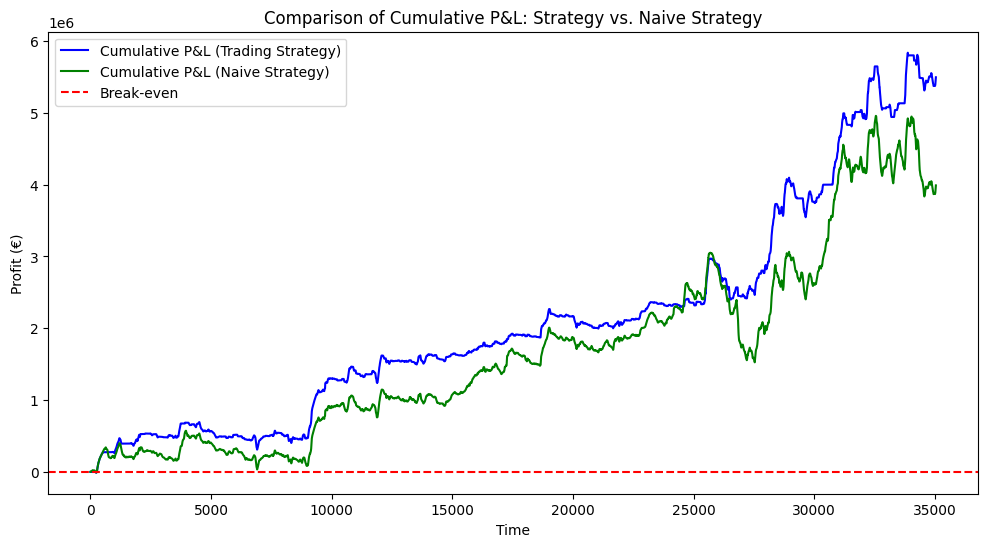

Total profit from the strategy: €5,495,076.60
Profit from the naive strategy: €3,989,575.47


In [23]:
threshold_high = 14000  # Production > 14000 MW => sell (short position)
threshold_low = 500    # Production < 500 MW => buy (long position)

position_size = 100

cumulative_pnl_strategy = 0
cumulative_pnl_naive = 0

daily_pnl_strategy = []
daily_pnl_naive = []

### Strategy

for index, row in data.iterrows():
    day_ahead_price = row['Day Ahead Price hourly [in EUR/MWh]']

    wind_day_ahead = row['Wind Day Ahead Forecast [in MW]']
    pv_day_ahead = row['PV Day Ahead Forecast [in MW]']

    total_day_ahead_forecast = wind_day_ahead + pv_day_ahead

    if total_day_ahead_forecast >= threshold_high:
        trade_pnl = -(day_ahead_price - row['Intraday Price Hourly  [in EUR/MWh]']) * position_size
        cumulative_pnl_strategy += trade_pnl
    elif total_day_ahead_forecast <= threshold_low:
        trade_pnl = -(row['Intraday Price Hourly  [in EUR/MWh]'] - day_ahead_price) * position_size
        cumulative_pnl_strategy += trade_pnl

    daily_pnl_strategy.append(cumulative_pnl_strategy)

data['Cumulative PnL Strategy'] = daily_pnl_strategy


### Naive strategy

for index, row in data.iterrows():
    day_ahead_price = row['Day Ahead Price hourly [in EUR/MWh]']



        # sell (short position)
    trade_pnl = -(day_ahead_price - row['Intraday Price Hourly  [in EUR/MWh]']) * position_size
    cumulative_pnl_naive += trade_pnl


    daily_pnl_naive.append(cumulative_pnl_naive)

data['Cumulative PnL Naive'] = daily_pnl_naive


plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative PnL Strategy'], label="Cumulative P&L (Trading Strategy)", color='blue')
plt.plot(data.index, data['Cumulative PnL Naive'], label="Cumulative P&L (Naive Strategy)", color='green')
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.title("Comparison of Cumulative P&L: Strategy vs. Naive Strategy")
plt.xlabel("Time")
plt.ylabel("Profit (€)")
plt.legend()
plt.show()

total_profit_strategy = data['Cumulative PnL Strategy'].iloc[-1]
total_profit_naive = data['Cumulative PnL Naive'].iloc[-1]

print(f"Total profit from the strategy: €{total_profit_strategy:,.2f}")
print(f"Profit from the naive strategy: €{total_profit_naive:,.2f}")

Our designed strategy outperforms the naive one. Further improvements could be achieved by optimizing the thresholds.

The task requires designing a trading strategy based on the relationship between day-ahead hourly prices and intraday hourly prices. However, we could also develop a strategy using intraday hourly prices and imbalance hourly prices, leveraging intraday renewable energy forecasts (this information could not have been used in our case without introducing forward-looking bias)